## Carbon-I Testbed Prototype

A prototype instrument has already been developed at JPL to demonstrate the Carbon-I measurement concept. This **testbed** incorporates a Dyson block, grating, and focal-plane array (FPA) matching Carbon-I’s anticipated optical design and performance specifications. Through laboratory measurements, the testbed can validate key elements such as **spectral resolution**, **imaging fidelity**, **throughput**, and **straylight** characteristics. These  demonstrations can confirm that Carbon-I’s architecture is both **technically feasible** and **robust**, ensuring confidence as we proceed toward a flight-ready instrument. 

In its current setup, the **testbed spectra** are measured under a **warm environment**, so the system is not fully aligned at flight operating temperatures. Consequently, the **spectral response function (SRF)** in these early demonstrations will appear more **fuzzy** than what we expect under cold, flight-like alignment conditions—a refinement that will be investigated in subsequent testbed campaigns.

---

Below, we walk through the **testbed-spectra fitting** procedure using measurements from a **light source** paired with a **CH<sub>4</sub> gas cell**. All examples here leverage the **Julia** programming language, chosen for its **high-level syntax** and **near-C speed**, making it ideally suited for the **Carbon-I** data processing pipeline. 

> First, we need to import some packages in Julia

In [1]:
using Pkg
Pkg.activate("../.."); # Actives the environment at the root of the project
# Using our Carbon-I and vSmartMOM packages (developed by our team)
using CarbonI, vSmartMOM
# Using standard Julia packages for Linear albegra, Differentiation, etc.
using SpecialPolynomials, FiniteDiff, LinearAlgebra
using DelimitedFiles, ImageFiltering, ForwardDiff, DiffResults
# Using the Makie package for plotting
using CairoMakie
include(joinpath("../../src/Plots", "CI_colorsNew.jl"))

  Activating project at `~/code/gitHub/CarbonI`
┌ Info: CUDA-enabled GPU(s) detected
└ @ vSmartMOM /home/cfranken/.julia/packages/vSmartMOM/a7WZC/src/vSmartMOM.jl:57
┌ Info: CUDA.CuDevice(0): NVIDIA A100-PCIE-40GB
└ @ vSmartMOM /home/cfranken/.julia/packages/vSmartMOM/a7WZC/src/vSmartMOM.jl:59
┌ Info: CUDA.CuDevice(1): NVIDIA A100-PCIE-40GB
└ @ vSmartMOM /home/cfranken/.julia/packages/vSmartMOM/a7WZC/src/vSmartMOM.jl:59


pwd()

> Reading in the testbed spectra, stored as simple CSV file:

In [2]:
testbed_ch4_cold = readdlm("../../data/CITB/20250402-CITB-Methane.csv",',');

> Loading Methane Spectroscopy from a pre-computed cross section table (tools included in vSmartMOM) and then computing the cross section of CH<sub>4</sub>  at the temperature and pressure in the laboratory (WAGs)

In [3]:
# Load Cross section database
ch4 = vSmartMOM.load_interpolation_model(CarbonI.xs_folder*"/ch4_model.jld2")
co = vSmartMOM.load_interpolation_model(CarbonI.xs_folder*"/co_model.jld2")
# Generate cross section at TestBed condition
p = 940.0 # Pressure in hPa
T = 295.0 # Temperature in K
Δwl = 0.005 # Resolution in nm
# Define high resolution wavelength grid (needs to be larger than the Carbon-I wavelength range to account for the SRF impact at the edges)
wl_grid_hr = 2030:Δwl:2398
xs_ch4  = reverse(vSmartMOM.absorption_cross_section(ch4, wl_grid_hr, p, T; wavelength_flag=true));
xs_co  = reverse(vSmartMOM.absorption_cross_section(co, wl_grid_hr, p, T; wavelength_flag=true)); # Has to be reversed to match the order of the data (as table is in wavenumber)

> Define an Instrument function (using tools developed in Carbon-I), modeling the Spectral Response Function as a mix of two boxcar functions (for slit and detector pixel) as well as a Gaussian (for optical effects)

In [4]:
# Define an instrument (Convolution of 2 Box kernels with a Gaussian):
FWHM  = 0.65  # Full Width at Half Maximum in nm 
SSI  = 0.7   # Spectral Sampling Interval in nm
# Define the kernels:
# Spectral response function of the slit (2*SSI)
kern1 = CarbonI.box_kernel(1.6*SSI, Δwl)
# Spectral response function of the optics (Gaussian)
kern2 = CarbonI.gaussian_kernel(FWHM, Δwl)
# Spectral response function of the pixel (1*SSI)
kern3 = CarbonI.box_kernel(SSI, Δwl)
# Combine the kernels:
kernf = imfilter(imfilter(kern1, kern2), kern3)
# Generate the instrument (stores convolution kernel and wavelength grid):
CarbonI_SRF = CarbonI.KernelInstrument(kernf, collect(2036.7:SSI:2394.4));

> Model Transmission with a first guess of the vertical column density in the cell (8e19molec/cm2 here, which is roughly a double-pass through the atmosphere).

In [5]:
vcd = 3.4e20 # molec/cm²
# Transmission of entire cell:
T_CH4 = exp.(-xs_ch4*vcd)
# Transmission of instrument:
T_CH4_conv = CarbonI.conv_spectra(CarbonI_SRF, wl_grid_hr, T_CH4);

> Plot the **unfitted** modeled and measured spectra as well as the high resolution transmission computed before convolution to the Carbon-I grid

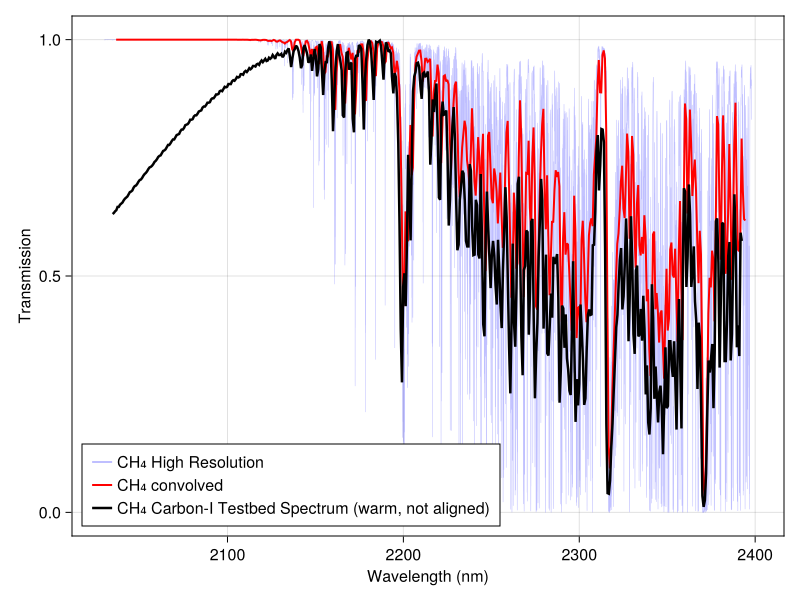

In [6]:
f = Figure(resolution = (800, 600))
ax = Axis(f[1, 1], xlabel = "Wavelength (nm)", ylabel = "Transmission")
lines!(ax, wl_grid_hr, T_CH4, color = :blue, linewidth = 0.5, alpha=0.25, label = "CH₄ High Resolution")
lines!(ax, CarbonI_SRF.ν_out, T_CH4_conv, color = :red, linewidth = 2.0, label = "CH₄ convolved")
lines!(ax, testbed_ch4_cold[:,1], testbed_ch4_cold[:,2]./maximum(testbed_ch4_cold[:,2]), color = :black, linewidth = 2.5, label = "CH₄ Carbon-I Testbed Spectrum (warm, not aligned)")
axislegend(position = :lb)
f

### Setting up a spectral fit

---

Now comes one of the most important parts of our fitting routine: **establishing a simple forward model** for the testbed spectra. Below is an example function in **Julia** that takes in a state vector containing parameters like wavelength offset, vertical column density, and instrument SRF specifications, and returns the modeled transmission curve. This function references **CH₄ cross sections**, applies **kernels** to simulate Carbon-I’s instrument resolution, and multiplies the resulting convolved spectrum by a **baseline polynomial** term to account for broad-band absorption structures that might come from the gas cell windows (similar to how surface albedo variationscan vary the broad-band variations in observed spectra when measured from space).

---

First, we define a simple forward model F(x) that maps our state vector x to modeled measurements.  x includes spectral calibration, vertical column density of the target gas, FWHM of the SRF, polynomial for broad band features.

In [7]:
# Set up a simple forward model to fit the data
function forward_model_testbed(x::AbstractArray{FT} ;xs = xs, wl_grid_hr = wl_grid_hr, Δwl=Δwl, ind=ind) where {FT}
    ############# Extract the parameters of the state vector: ################  
    # Start Wavelength
    wl_start = x[1]
    # SSI
    SSI = x[2]
    # SSI change in square
    SSI_square  = x[3]
    # Fixed grid subset for now:
    # ind = 50:500
    # Compute Carbon-I grid as 2nd order polynomial of the index
    carbonI_wlGrid = wl_start .+ ind * SSI .+  ind.^2 * SSI_square
    # Vertical Column density (in molec/cm2):
    vcd = x[4]
    # FWHM (Full Width at Half Maximum)
    FWHM = x[5]
    # Poynomial terms
    poly = Legendre(x[6:end])

    ############# Start of the forward model ################################  
    # Compute total optical thickness (cross section * vertical column density)
    τ = xs * vcd
    # Compute Transmission
    T = exp.(-τ)
    #@show T
    # Define the instrument SRF:
    #SSI  = 0.7
    # Kernel 1 simulates slit width as boxcar:
    kern1 = CarbonI.box_kernel(1.6SSI, Δwl)
    # Gaussian kernel simulates the resolution of the instrument:
    kern2 = CarbonI.gaussian_kernel(FWHM, Δwl)
    # Kernel 3 reresents the pixel itself (1*SSI boxcar)
    kern3 = CarbonI.box_kernel(SSI, Δwl)
    # Combine the kernels, basically a multiplication of their Fourier Transforms:
    kernf = imfilter(imfilter(kern1, kern2), kern3)
    # Generate the Carbon-I SRF kernel (which includes resampling to the final grid)
    CarbonI_SRF = CarbonI.KernelInstrument(kernf, carbonI_wlGrid);
    
    # Convolve with instrument function
    T_conv = CarbonI.conv_spectra(CarbonI_SRF, wl_grid_hr, T)
    x_poly = CarbonI.rescale_x(CarbonI_SRF.ν_out)
    # Multiply Convolved transmission with the baseline polynomial
    return T_conv .* poly.(x_poly)
end

# Just a simple function to compute the grid from the state vector outside of the forward model (lazy)
function getGrid(x; ind=ind)
    wl_start = x[1]
    # SSI
    SSI = x[2]
    # SSI change in square
    SSI_square  = x[3]
    
    carbonI_wlGrid = wl_start .+ ind * SSI .+  ind.^2 * SSI_square
    return carbonI_wlGrid
end

getGrid (generic function with 1 method)

> Now we can define a **prior** state vector and run the forward model. Note that this is **not optimized** but just evaluation the forward model at our first guess

In [8]:
xs = xs_ch4;
x = [2032.5, 0.7, 0,  4.8e20, 0.5,  1.0, 0.0e-10, 0.0e-10, 0.0e-10, 0.0e-10,0.0e-10, 0.0e-10, 0.0e-10,0.0e-10,0.0e-10, 0.0e-10,0.0e-10];
ind = 101:500
yy = forward_model_testbed(x);
wl_grid = getGrid(x);

# Set Gas to CH4:
# Switch CH4 to CO:


400-element Vector{Float64}:
 2103.2
 2103.9
 2104.6
 2105.3
 2106.0
 2106.7
 2107.4
 2108.1
 2108.8
 2109.5
    ⋮
 2376.9
 2377.6
 2378.3
 2379.0
 2379.7
 2380.4
 2381.1
 2381.8
 2382.5

> Now we just plot it overlay the measured spectrum. It looks pretty good but is of course not yet **optimized**, i.e. we aim to minimize the squared residuals of (y-F(x))

In [9]:

function plotFit()
    f = Figure(resolution = (800, 600))
    ax = Axis(f[1, 1], xlabel = "Wavelength (nm)", ylabel = "Transmission")
    lines!(ax, wl_grid, yy, color = :red, linewidth = 2.0, label = "modeled CH₄ convolved")
    lines!(ax, testbed_ch4_cold[ind.+2,1], testbed_ch4_cold[ind,2]./maximum(testbed_ch4_cold[ind,2]), color = :gray, linewidth = 2.5, label = "CH₄ Carbon-I Testbed Spectrum (warm, not aligned)")
    
    axislegend(position = :lb)
    f
end

plotFit (generic function with 1 method)

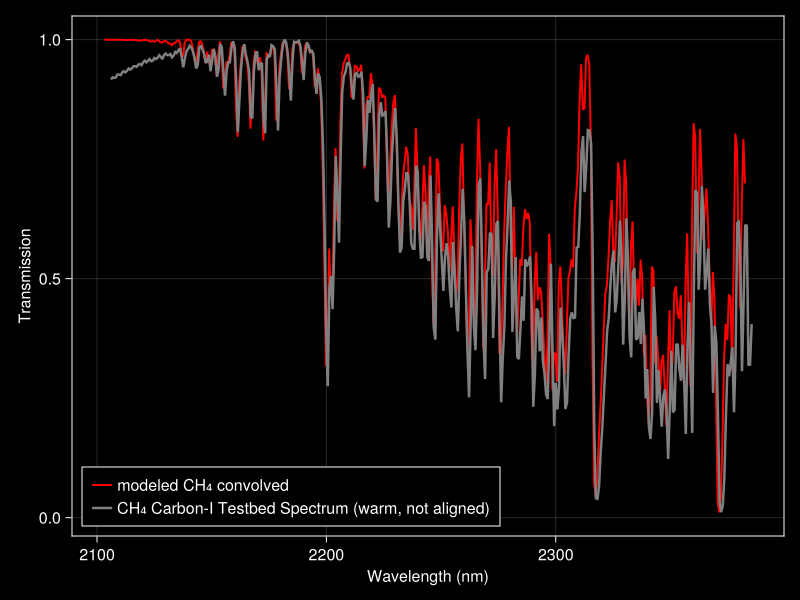

In [10]:
with_theme(plotFit, theme_black())

> Now we can set up an actual first defining the prior and error covariance matrices (a bit overkill for this application but is provides flexibility)

In [36]:
# Define the detector indices to include in the fit:
ind = 101:500

# Number of iterations:
n_iter = 8
# Initiate 2D array to store the state vector at each iteration
x_all = zeros(length(x),n_iter+1);
# Use the testbed spectrum divided by its maximum as input spectrum to be fitted:
y_cold = testbed_ch4_cold[:,2]./maximum(testbed_ch4_cold[:,2]);
# Subselect only for the given detector indices (offset by 1 as Julia is one-index based)
y_cold = y_cold[ind.-3];
# Set the prior of the first polynmial term to the maximum of the measured spectrum (this ensures less iterations!)
x[6] = maximum(y_cold)
# Set first guess as the first column of the state vector array
x_all[:,1] .= x;
# Set Pior state vector to what we used before (which is far enough from the true solution)
xa = x;

# Define the measurement error covariance matrix (see CSR Box). This is arbitrarily chose here, in real life and simulations we use an instrument model to estimate this.
Se = Diagonal((0.001*y_cold).^2);
# Define prior covariance matrix (see CSR Box). 
Sa = zeros(length(x),length(x));
Sa[1,1] = 0.1^2; # For the start wavelength
Sa[2,2] = 0.002^2; # For the SSI
Sa[3,3] = 10e-6^2; # For the SSI square
Sa[4,4] = 500e20^2; # For the CH4 VCD
Sa[5,5] = 0.025^2;  # For the FWHM (in nm)

# For polynomial terms *basically unconstrained)
for i=6:length(x)
    Sa[i,i] = 1^2;
end

In [37]:
# run iterations  for all windows:
xs = xs_ch4
for i=1:n_iter
    K = FiniteDiff.finite_difference_jacobian(forward_model_testbed,x_all[:,i]);
    # Perfom nonlinear Bayesian update (following Rodgers)
    F = forward_model_testbed(x_all[:,i]);
    #@show size(K)
    iGain = inv(K'inv(Se)K + inv(Sa))K'inv(Se);
    # Compute retrieved state vector at iteration i
    x_all[:,i+1] = xa + iGain * (y_cold - F + K *(x_all[:,i]-xa));
end
x_fit_cold = x_all[:,end];



In [14]:
# run iterations for micro windows:
xs = xs_ch4
fit_results = []
for mw_start = 1:30:399
    for i=1:n_iter
        mw = mw_start:(minimum([mw_start+40,399]));
        Se = Diagonal((100*y_cold).^2);
        Se[mw,mw] = Diagonal((0.001*y_cold[mw]).^2);
        K = FiniteDiff.finite_difference_jacobian(forward_model_testbed,x_all[:,i]);
        # Perfom nonlinear Bayesian update (following Rodgers)
        F = forward_model_testbed(x_all[:,i]);
        #@show size(K)
        iGain = inv(K'inv(Se)K + inv(Sa))K'inv(Se);
        # Compute retrieved state vector at iteration i
        x_all[:,i+1] = xa + iGain * (y_cold - F + K *(x_all[:,i]-xa));
    end
    x_fit_cold = x_all[:,end];
    push!(fit_results, x_fit_cold)
end

DomainError: DomainError with -19.729045495519454:
Normal: the condition σ >= zero(σ) is not satisfied.

In [27]:
# Reconstruct modeled spectrum from MW fits:
y_all_mw = zeros(length(ind))
for (i,mw_start) in enumerate(1:30:399)

    mw = maximum([1,mw_start+5]):(minimum([mw_start+35,399]));
    y_all_mw[mw] = forward_model_testbed(fit_results[i])[mw];
    @show mw
end




mw = 6:36
mw = 36:66
mw = 66:96
mw = 96:126
mw = 126:156
mw = 156:186
mw = 186:216
mw = 216:246
mw = 246:276
mw = 276:306
mw = 306:336
mw = 336:366
mw = 366:396


BoundsError: BoundsError: attempt to access 13-element Vector{Any} at index [14]

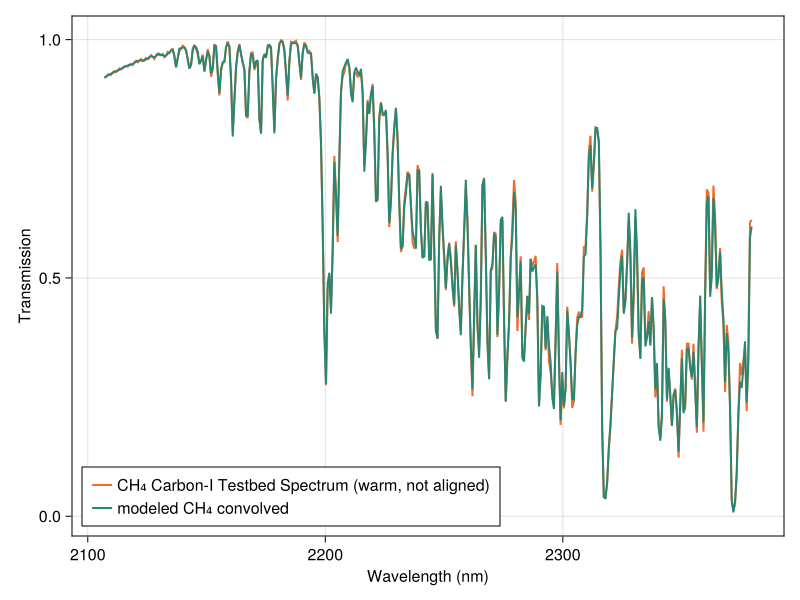

In [33]:
#x_all[1,1] = 2032.5
#F_cold = forward_model_testbed(x_all[:,1])
wl_grid = getGrid(fit_results[3]);
f = Figure(resolution = (800, 600))
    ax = Axis(f[1, 1], xlabel = "Wavelength (nm)", ylabel = "Transmission")
    lines!(ax, wl_grid[6:end-5], y_cold[6:end-5], color = CarbonI_colors[5], linewidth = 2, label = "CH₄ Carbon-I Testbed Spectrum (warm, not aligned)")
    lines!(ax, wl_grid[6:end-5], y_all_mw[6:end-5], color = CarbonI_colors[3], linewidth = 2, label = "modeled CH₄ convolved")
    axislegend(position = :lb)
f

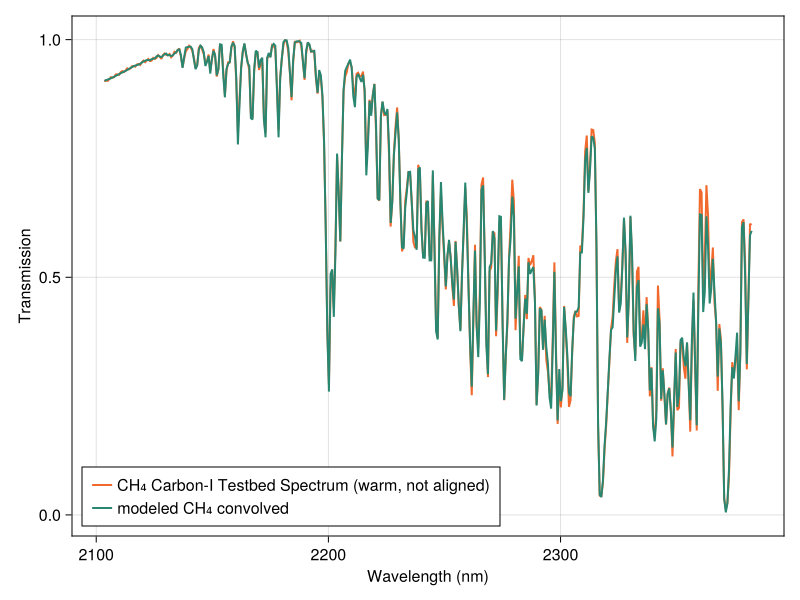

In [108]:
F_cold = forward_model_testbed(x_fit_cold);
#x_all[1,1] = 2032.5
#F_cold = forward_model_testbed(x_all[:,1])
wl_grid = getGrid(x_fit_cold);
f = Figure(resolution = (800, 600))
    ax = Axis(f[1, 1], xlabel = "Wavelength (nm)", ylabel = "Transmission")
    lines!(ax, wl_grid, y_cold, color = CarbonI_colors[5], linewidth = 2, label = "CH₄ Carbon-I Testbed Spectrum (warm, not aligned)")
    lines!(ax, wl_grid, F_cold, color = CarbonI_colors[3], linewidth = 2, label = "modeled CH₄ convolved")
    axislegend(position = :lb)
f

> Now we can run the iterative fit (arbitray cutoff here) and save all results per iteration

off = -1401
fwhm = -1.41


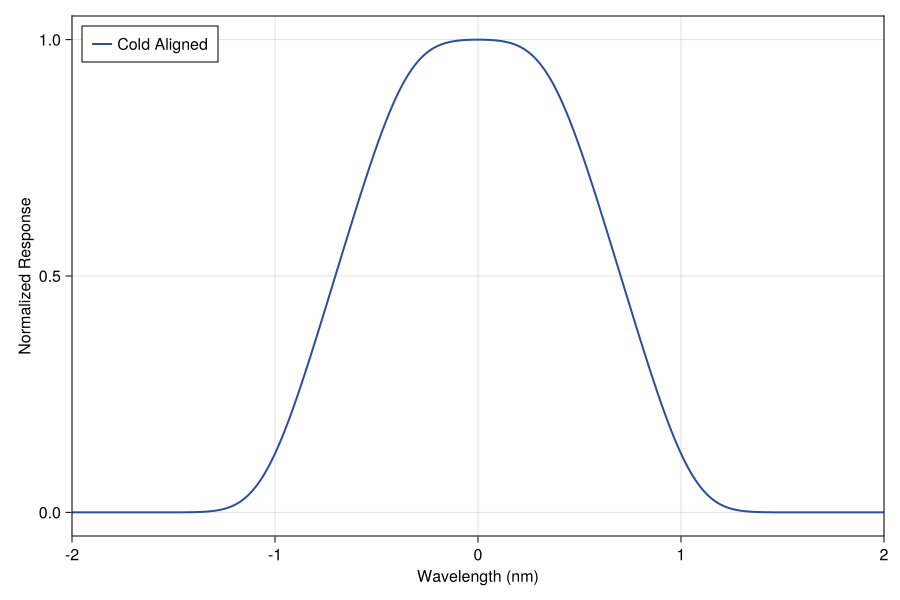

In [109]:
#plot(CarbonI_SRF_cold.ν_out, CarbonI_SRF_cold.kernel, color = :red, linewidth = 2, label = "Cold")

# Kernel 1 simulates slit width as boxcar:
kern1 = CarbonI.box_kernel(2SSI, Δwl)
# Gaussian kernel simulates the resolution of the instrument:
kern2 = CarbonI.gaussian_kernel(0.33  , Δwl)
# Kernel 3 reresents the pixel itself (1*SSI boxcar)
kern3 = CarbonI.box_kernel(SSI, Δwl)
# Combine the kernels, basically a multiplication of their Fourier Transforms:
kernf = imfilter(imfilter(kern1, kern2), kern3)
# Generate the Carbon-I SRF kernel (which includes resampling to the final grid)
#CarbonI_SRF_warm = CarbonI.KernelInstrument(kernf, wl_warm);
#kern2 = CarbonI.gaussian_kernel(x_fit_cold[5]  , Δwl)
#kernf = imfilter(imfilter(kern1, kern2), kern3)
# Generate the Carbon-I SRF kernel (which includes resampling to the final grid)
CarbonI_SRF_cold = CarbonI.KernelInstrument(kernf, wl_grid);

off = CarbonI_SRF_cold.kernel.offsets[1]
@show off
xx = off+1:-off-1
f = Figure(resolution = (900, 600))
        ax = Axis(f[1, 1], xlabel = "Wavelength (nm)", ylabel = "Normalized Response")
        lines!(ax, Δwl .* xx,CarbonI_SRF_cold.kernel.parent./maximum(CarbonI_SRF_cold.kernel.parent), color = CarbonI_colors[4], linewidth = 2, label = "Cold Aligned")
        #lines!(ax, Δwl .* xx,CarbonI_SRF_warm.kernel.parent./maximum(CarbonI_SRF_warm.kernel.parent), color = CarbonI_colors[5], linewidth = 2, label = "Warm (initital) Aligned")

        axislegend(position = :lt)
        xlims!(-2, 2)
    f

find_fwhm = argmin(abs.(CarbonI_SRF_cold.kernel.parent./maximum(CarbonI_SRF_cold.kernel.parent) .-0.5));
fwhm = 2*(find_fwhm+off)*Δwl
@show fwhm
#find_fwhm = argmin(abs.(CarbonI_SRF_warm.kernel.parent./maximum(CarbonI_SRF_warm.kernel.parent) .-0.5));
#fwhm = 2*(find_fwhm+off)*Δwl
#@show fwhm
f

In [223]:
# Kernel 1 simulates slit width as boxcar:
kern1 = CarbonI.box_kernel(2SSI, Δwl)
# Gaussian kernel simulates the resolution of the instrument:
kern2 = CarbonI.gaussian_kernel(x_fit_cold[5]  , Δwl)
# Kernel 3 reresents the pixel itself (1*SSI boxcar)
kern3 = CarbonI.box_kernel(SSI, Δwl)
# Combine the kernels, basically a multiplication of their Fourier Transforms:
kernf = imfilter(imfilter(kern1, kern2), kern3)
# Generate the Carbon-I SRF kernel (which includes resampling to the final grid)
#CarbonI_SRF_warm = CarbonI.KernelInstrument(kernf, wl_warm);
kern2 = CarbonI.gaussian_kernel(x_fit_cold[5]  , Δwl)
kernf = imfilter(imfilter(kern1, kern2), kern3)
# Generate the Carbon-I SRF kernel (which includes resampling to the final grid)
CarbonI_SRF_cold = CarbonI.KernelInstrument(kernf, wl_grid);
wl_grid = getGrid(x_fit_cold);
F_cold = forward_model_testbed(x_fit_cold);
@show size(F_cold), size(wl_grid)
function plotFitBoth()
    f = Figure(resolution = (700, 600), backgroundcolor=:transparent)
        ax1 = Axis(f[1, 1],  ylabel = "Cross-Track", title="Carbon-I Prototype CH₄ Spectrum")
        heatmap!(ax1,wl_grid, 1040:1090, img[1040:1090,ind]')
        poly!(Point2f[(wl_grid[1], 1055), (wl_grid[end], 1055), (wl_grid[end], 1068), (wl_grid[1], 1068)],color=(:red, 0.0),strokecolor = CarbonI_colors[1], strokewidth = 2)
        #arrows!(ax1,wl_grid[50], 1055, -10, -100, arrowsize = 10, lengthscale = 0.3, arrowcolor =  CarbonI_colors[1], linecolor =  CarbonI_colors[1])

        ax = Axis(f[2, 1], xlabel = "Wavelength (nm)", ylabel = "Transmission")
        #lines!(ax, wl_warm, F_warm .+0.2, color = CarbonI_colors[3], linewidth = 2, label = "modeled CH₄ convolved")
        #lines!(ax, wl_warm, y_warm .+0.2, color = CarbonI_colors[5], linewidth = 2, label = "CH₄ Testbed Spectrum (warm, initial alignment)")
        
        lines!(ax, wl_grid, F_cold, color = CarbonI_colors[3], linewidth = 2, label = "Modeled CH₄ spectrum")
        lines!(ax, wl_grid, y_cold, color = CarbonI_colors[1], linewidth = 2, label = "Measured CH₄ spectrum")
        lines!(ax, wl_grid, (y_cold-F_cold), color = CarbonI_colors[5], linewidth = 2, label = "Residual (measured-modeled)")
        
        ax_inset = Axis(f[2, 1],xlabel = "Δλ (nm)", ylabel = "Normalized Response",#backgroundcolor = :white,
        width=Relative(0.2),
        height=Relative(0.2),
        halign=0.12,
        valign=0.37,
        title="Fitted SRF (FWHM)")
        lines!(ax_inset, Δwl .*(-1400:1400),CarbonI_SRF_cold.kernel.parent./maximum(CarbonI_SRF_cold.kernel.parent), color = CarbonI_colors[4], linewidth = 2, label = "Cold Aligned")
        #lines!(ax_inset, Δwl .*(-1400:1400),CarbonI_SRF_warm.kernel.parent./maximum(CarbonI_SRF_warm.kernel.parent), color = CarbonI_colors[5], linewidth = 2, label = "Warm (initital) Aligned")
        xlims!(ax_inset, -2, 2)
        lines!(ax_inset, [-1.25, 1.25], [0.5, 0.5], color = :gray, linewidth = 2, label="Required FWHM")
        lines!(ax_inset, [-0.85, 0.85], [0.5, 0.5], color = :red, linewidth = 2, label="CBE FWHM")
        text!(ax_inset, "Req.", position = (1.15, 0.6), align = (:left, :bottom), color = :gray, fontsize=10)
        text!(ax_inset, "CBE", position = (1.15, 0.8), align = (:left, :bottom), color = :red, fontsize=10)
        axislegend(ax,position = :rt)
        #axislegend(ax_inset,position = :lt)
        hidexdecorations!(ax1)
        xlims!(ax,2110, 2380)
        rowsize!(f.layout, 1, Relative(0.5/3))
        rowgap!(f.layout, 1, Relative(0.01))
        resize_to_layout!(f)
    f
end

(size(F_cold), size(wl_grid)) = ((400,), (400,))


plotFitBoth (generic function with 1 method)

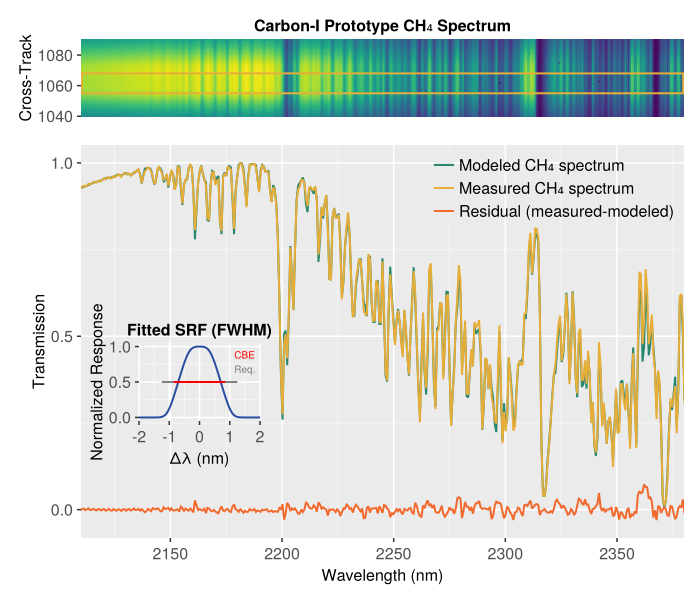

In [224]:
ff = with_theme(plotFitBoth, theme_ggplot2())
save( "../../plots/final/CH4_Cold_Aligned-ALL.pdf", ff)
ff

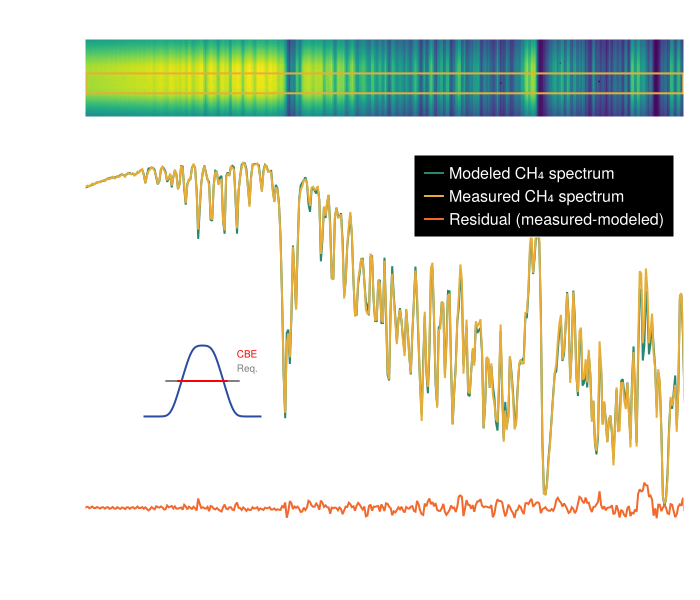

In [225]:
ff = with_theme(plotFitBoth, theme_black())
save( "../../plots/final/CH4_Cold_Aligned-ALL_black.pdf", ff)
ff


> Extract the best fit (last iteration)

In [41]:
function load2d(file; dims=(3072,513 ))
    bytes =  read(file);
    # Reinterpret the byte array as Float32 values
    data = reinterpret(Float32, bytes)
    # If you need a standard Vector, you can collect it:
    data_vec = collect(data)
    reshape(data_vec, dims)
end
#using Plots
using Printf

# Change to the working directory for the given date
date = "20250402"
pwd()
path = joinpath("../../data/CITB/", date)
roi = (800, 1300)  # Region of interest for detector columns

# Spectral calibration "by eye" from methane absorption features:
# Create an array of wavelengths from 2034 nm with 0.7 nm spacing
xx = (0:512) .* 0.7 .+ 2034  # length 513

# Define the expected shape of the binary data (rows, columns)
shape = (513, 3072)

# Read the binary files into matrices of Float32
bck  = load2d(path*"-CH4-in-long-cell-OPEN")
drk  = load2d(path*"-CH4-in-long-cell-Dark")
spc1 = load2d(path*"-CH4-in-long-cell")

# Compute the images: subtract the dark current from signal and background
img = spc1 .- drk
bck .-= drk

3072×513 Matrix{Float32}:
 4126.0   0.398926   1.47803  …  1.67603  1.42908  1.53503  1.38306
    0.0  20.697     -2.26367     1.69397  1.54004  1.203    1.68298
    0.0  19.359     19.996       1.62097  1.95691  1.34009  1.33899
    0.0  19.992     19.724       1.48291  2.05493  1.41199  1.27209
    0.0  19.535     19.5699      1.2771   1.72205  1.35303  1.495
    0.0  20.13      19.9929   …  1.2229   1.802    1.38708  1.39795
    0.0  19.873     19.59        1.65796  1.71497  1.30005  1.48096
    0.0  19.452     19.325       1.20398  1.09204  1.078    1.94507
    0.0  19.852     20.3159      1.85706  1.64697  1.23706  1.29504
    0.0  19.6949    19.7311      1.44995  1.20801  1.41504  1.37793
    ⋮                         ⋱           ⋮                 
    0.0   6.67499    6.61096     1.57202  1.78699  1.82397  1.92505
    0.0   6.84503    6.49799     1.51703  1.46997  1.51599  1.46692
    0.0   6.70099    6.67303  …  1.39209  1.73199  1.72699  1.91205
    0.0   6.85803    6.81      

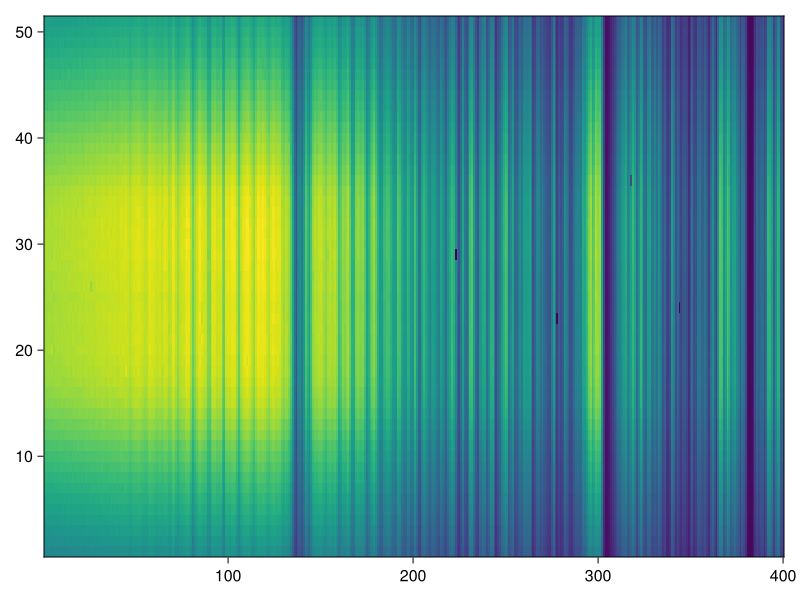

In [159]:
heatmap(img[1040:1090,ind]')

In [ ]:
using Statistics
# Kernel 1 simulates slit width as boxcar:
kern1 = CarbonI.box_kernel(2SSI, Δwl)
# Gaussian kernel simulates the resolution of the instrument:
fwhm_g = mean([a[5] for a in  fit_results])
kern2 = CarbonI.gaussian_kernel(fwhm_g  , Δwl)
# Kernel 3 reresents the pixel itself (1*SSI boxcar)
kern3 = CarbonI.box_kernel(SSI, Δwl)
# Combine the kernels, basically a multiplication of their Fourier Transforms:
kernf = imfilter(imfilter(kern1, kern2), kern3)
# Generate the Carbon-I SRF kernel (which includes resampling to the final grid)
#CarbonI_SRF_warm = CarbonI.KernelInstrument(kernf, wl_warm);
kern2 = CarbonI.gaussian_kernel(x_fit_cold[5]  , Δwl)
kernf = imfilter(imfilter(kern1, kern2), kern3)
# Generate the Carbon-I SRF kernel (which includes resampling to the final grid)
CarbonI_SRF_cold = CarbonI.KernelInstrument(kernf, wl_grid);
wl_grid = getGrid(x_fit_cold);
F_cold = forward_model_testbed(x_fit_cold);
@show size(F_cold), size(wl_grid)
function plotFitBoth_mw()
    f = Figure(resolution = (700, 600))#, backgroundcolor=:transparent)
        ax1 = Axis(f[1, 1],  ylabel = "Cross-Track", title="Carbon-I Prototype CH₄ Spectrum")
        heatmap!(ax1,wl_grid, 1040:1090, img[1040:1090,ind]')
        poly!(Point2f[(wl_grid[1+5], 1055), (wl_grid[end-5], 1055), (wl_grid[end-5], 1068), (wl_grid[1+5], 1068)],color=(:red, 0.0),strokecolor = CarbonI_colors[1], strokewidth = 2)
        #arrows!(ax1,wl_grid[50], 1055, -10, -100, arrowsize = 10, lengthscale = 0.3, arrowcolor =  CarbonI_colors[1], linecolor =  CarbonI_colors[1])

        ax = Axis(f[2, 1], xlabel = "Wavelength (nm)", ylabel = "Transmission")
        #lines!(ax, wl_warm, F_warm .+0.2, color = CarbonI_colors[3], linewidth = 2, label = "modeled CH₄ convolved")
        #lines!(ax, wl_warm, y_warm .+0.2, color = CarbonI_colors[5], linewidth = 2, label = "CH₄ Testbed Spectrum (warm, initial alignment)")
        
        lines!(ax, wl_grid[6:end-5], y_all_mw[6:end-5], color = CarbonI_colors[3], linewidth = 2, label = "Modeled CH₄ spectrum")
        lines!(ax, wl_grid[6:end-5], y_cold[6:end-5], color = CarbonI_colors[1], linewidth = 2, label = "Measured CH₄ spectrum")
        lines!(ax, wl_grid[6:end-5], (y_cold[6:end-5]-y_all_mw[6:end-5]), color = CarbonI_colors[5], linewidth = 2, label = "Residual (measured-modeled)")
        
        ax_inset = Axis(f[2, 1],xlabel = "Δλ (nm)", ylabel = "Normalized Response",#backgroundcolor = :white,
        width=Relative(0.2),
        height=Relative(0.2),
        halign=0.12,
        valign=0.37,
        title="Fitted SRF (FWHM)")
        lines!(ax_inset, [-1.25, 1.25], [0.5, 0.5], color = :gray, linewidth = 2, label="Required FWHM")
        lines!(ax_inset, [-1.25, -1.25], [0.45, 0.55], color = :gray, linewidth = 2)
        lines!(ax_inset, [1.25, 1.25], [0.45, 0.55], color = :gray, linewidth = 2)
        lines!(ax_inset, [-0.85, 0.85], [0.5, 0.5], color = :red, linewidth = 2, label="CBE FWHM")
        lines!(ax_inset, [-0.85, -0.85], [0.45, 0.55], color = :red, linewidth = 2)
        lines!(ax_inset, [0.85, 0.85], [0.45, 0.55], color = :red, linewidth = 2)
        lines!(ax_inset, Δwl .*(-1400:1400),CarbonI_SRF_cold.kernel.parent./maximum(CarbonI_SRF_cold.kernel.parent), color = CarbonI_colors[4], linewidth = 2, label = "Cold Aligned")
        #lines!(ax_inset, Δwl .*(-1400:1400),CarbonI_SRF_warm.kernel.parent./maximum(CarbonI_SRF_warm.kernel.parent), color = CarbonI_colors[5], linewidth = 2, label = "Warm (initital) Aligned")
        xlims!(ax_inset, -2, 2)
        
        text!(ax_inset, "Req.", position = (1.15, 0.6), align = (:left, :bottom), color = :gray, fontsize=10)
        text!(ax_inset, "CBE", position = (1.15, 0.8), align = (:left, :bottom), color = :red, fontsize=10)
        axislegend(ax,position = :rt)
        #axislegend(ax_inset,position = :lt)
        hidexdecorations!(ax1)
        xlims!(ax,2110, 2380)
        xlims!(ax1,2110, 2380)
        rowsize!(f.layout, 1, Relative(0.5/3))
        rowgap!(f.layout, 1, Relative(0.01))
        resize_to_layout!(f)
    f
end

(size(F_cold), size(wl_grid)) = ((400,), (400,))


plotFitBoth_mw (generic function with 1 method)

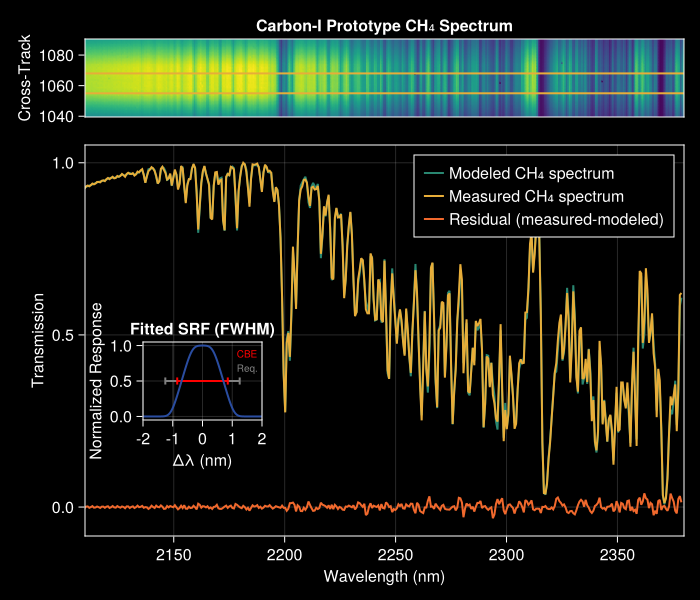

In [66]:
ff = with_theme(plotFitBoth_mw, theme_black())
save( "../../plots/final/CH4_Cold_Aligned-ALL_black_mw.pdf", ff)
ff

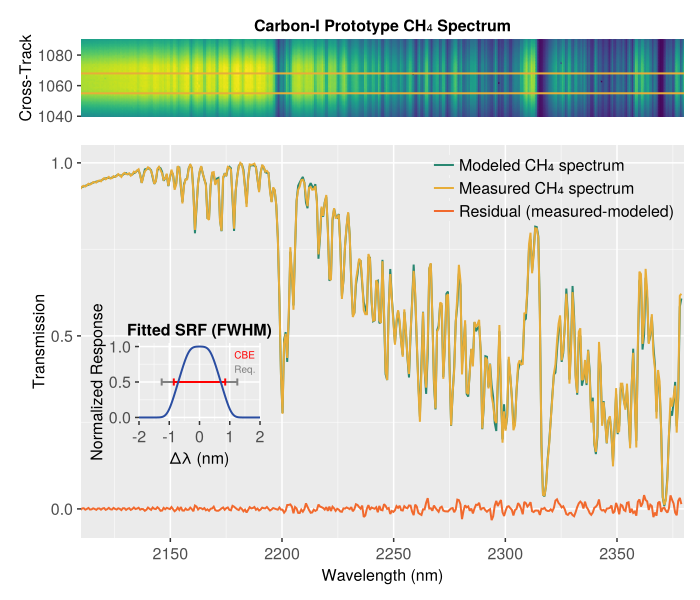

In [67]:
ff = with_theme(plotFitBoth_mw, theme_ggplot2())
save( "../../plots/final/CH4_Cold_Aligned-ALL_mw.pdf", ff)
ff